In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\onrik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Python


### 预处理

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','http','bit','ly','org'])

In [4]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [9]:
df = pd.read_excel("C:/Users/onrik\\report\\0203_LDA\\GDPR twitter 가공_0329.xlsx")
df.columns = ['date_1','content', 'date']
df = df[['date','content']]
df.head()

,date,content
0,2018-01-01,This is the kind of behavior that the EU GDPR ...
1,2018-01-03,@sapinker\n 님과 \n@GaryMarcus\n 님에게 보내는 답글\nAnd...
2,2018-01-03,A Publisher’s Guide To GDPR: AdExchanger | Wit...
3,2018-01-04,"@aral\n @Elektrojunge\n 님, 다른 사람 6명에게 보내는 답글\..."
4,2018-01-04,"2018PSD2, GDPR, MiFID2... excited to see how t..."


In [10]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

# print(data_words[:1])

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm") 
# nlp = spacy.load('zh_core_web_sm')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB'])

# print(data_lemmatized[:1])

In [14]:
data_lemmatized

[['gdpr',
  'created',
  'stop',
  'start',
  'violate',
  'law',
  'happen',
  'advertiser',
  'create',
  'invisible',
  'login',
  'form',
  'capture',
  'datum',
  'password',
  'manager',
  'willing',
  'auto',
  'fill',
  'username',
  's',
  'stop',
  'capture',
  'password',
  'block',
  'ad',
  'allow',
  'auto',
  'fill',
  'twitter',
  'com',
  'troyhunt',
  'status'],
 ['go',
  'big',
  'problem',
  'black',
  'box',
  'algorythm',
  'forbid',
  'regard',
  'personal',
  'datum',
  'need',
  'able',
  'explain',
  'automate',
  'decision',
  'forbid',
  'date',
  'gdpr'],
 ['publisher',
  'guide',
  'regulation',
  'gdpr',
  'set',
  'take',
  'effect',
  'dlvr',
  'privacy',
  'tweettothetop'],
 ['mention',
  'guids',
  'datum',
  'observe',
  'generate',
  'random',
  'value',
  'allow',
  'identify',
  'specific',
  'user',
  'device',
  'datum',
  'affect',
  'gdpr',
  'consider',
  'pii'],
 ['gdpr',
  'excited',
  'see',
  'world',
  'general',
  'particular',
  'chang

### TF-IDF

In [15]:
### Term-Frequency
from collections import Counter
words = ''
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    words += t
words = words.split()
counts = Counter(words)
counts

Counter({'gdpr': 3128,
         'created': 1,
         'stop': 37,
         'start': 71,
         'violate': 23,
         'law': 205,
         'happen': 38,
         'advertiser': 8,
         'create': 51,
         'invisible': 3,
         'login': 8,
         'form': 27,
         'capture': 9,
         'datum': 1221,
         'password': 14,
         'manager': 11,
         'willing': 5,
         'auto': 4,
         'fill': 14,
         'username': 1,
         's': 24,
         'block': 46,
         'ad': 60,
         'allow': 50,
         'twitter': 66,
         'com': 623,
         'troyhunt': 1,
         'statusgo': 1,
         'big': 96,
         'problem': 56,
         'black': 6,
         'box': 9,
         'algorythm': 1,
         'forbid': 6,
         'regard': 36,
         'personal': 222,
         'need': 205,
         'able': 26,
         'explain': 26,
         'automate': 11,
         'decision': 37,
         'date': 17,
         'gdprpublisher': 1,
         'guide': 22,


In [16]:
vocab = sorted(counts, key=counts.get, reverse=True)
tf_df = []
for voca in vocab:
    tf_df.append({'word': voca, 'term frequency': counts[voca]})
tf_df = pd.DataFrame(tf_df)
tf_df.head(10)

,word,term frequency
0,gdpr,3128
1,datum,1221
2,privacy,738
3,com,623
4,protection,287
5,company,267
6,new,262
7,dataprotection,255
8,compliance,243
9,regulation,234


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
contents_tfidf = []
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    contents_tfidf.append(t)
vectorizer = TfidfVectorizer(stop_words='english', max_features= 100)
X = vectorizer.fit_transform(contents_tfidf)

# # TF-IDF 행렬의 크기 확인
# print('TF-IDF 행렬의 크기 :',X.shape)
tf_idfdict=  vectorizer.get_feature_names()
data_array = X.toarray()
data_tdidf = pd.DataFrame(data_array, columns=tf_idfdict)
data_tdidf


,access,ai,apply,article,ask,big,blockchain,blog,breach,business,...,update,use,user,want,way,website,week,work,world,year
0,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.60537,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.621686,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.365001,0.335724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.558544,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3857,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3858,0.356946,0.0,0.0,0.333106,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.354714,0.0,0.0,0.000000,0.000000
3859,0.000000,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [18]:
def getTFIDF(text_series):
    """Performs TF-IDF calculation on a matrix of words grouped into cells."""
    vectorizer = TfidfVectorizer()

    matrix = vectorizer.fit_transform(text_series).todense()

    matrix_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())


    return matrix_df.sum(axis=0).sort_values(ascending=False)

# # Create Corpus for TD-IDF analysis 
text_df = pd.DataFrame()
text_df["text_clean"] = data_lemmatized # Use the data_lemmatized for text analysis
text_to_tfidf = [",".join(text) for text in text_df["text_clean"].values]

# Getting TD-IDF scores for words 
topwords = getTFIDF(text_to_tfidf)
topwords.to_excel("topwords.xlsx")
topwords_50 = topwords[:50]
topwords_50.to_excel("GDPR twitter_topwords_tf_idf_50.xlsx")

In [19]:
topwords

gdpr            246.501365
datum           126.263311
privacy          96.050247
com              71.205550
compliance       47.679773
                   ...    
interception      0.127691
europol           0.127691
elast             0.100614
ons               0.077746
assetstore        0.077746
Length: 7599, dtype: float64

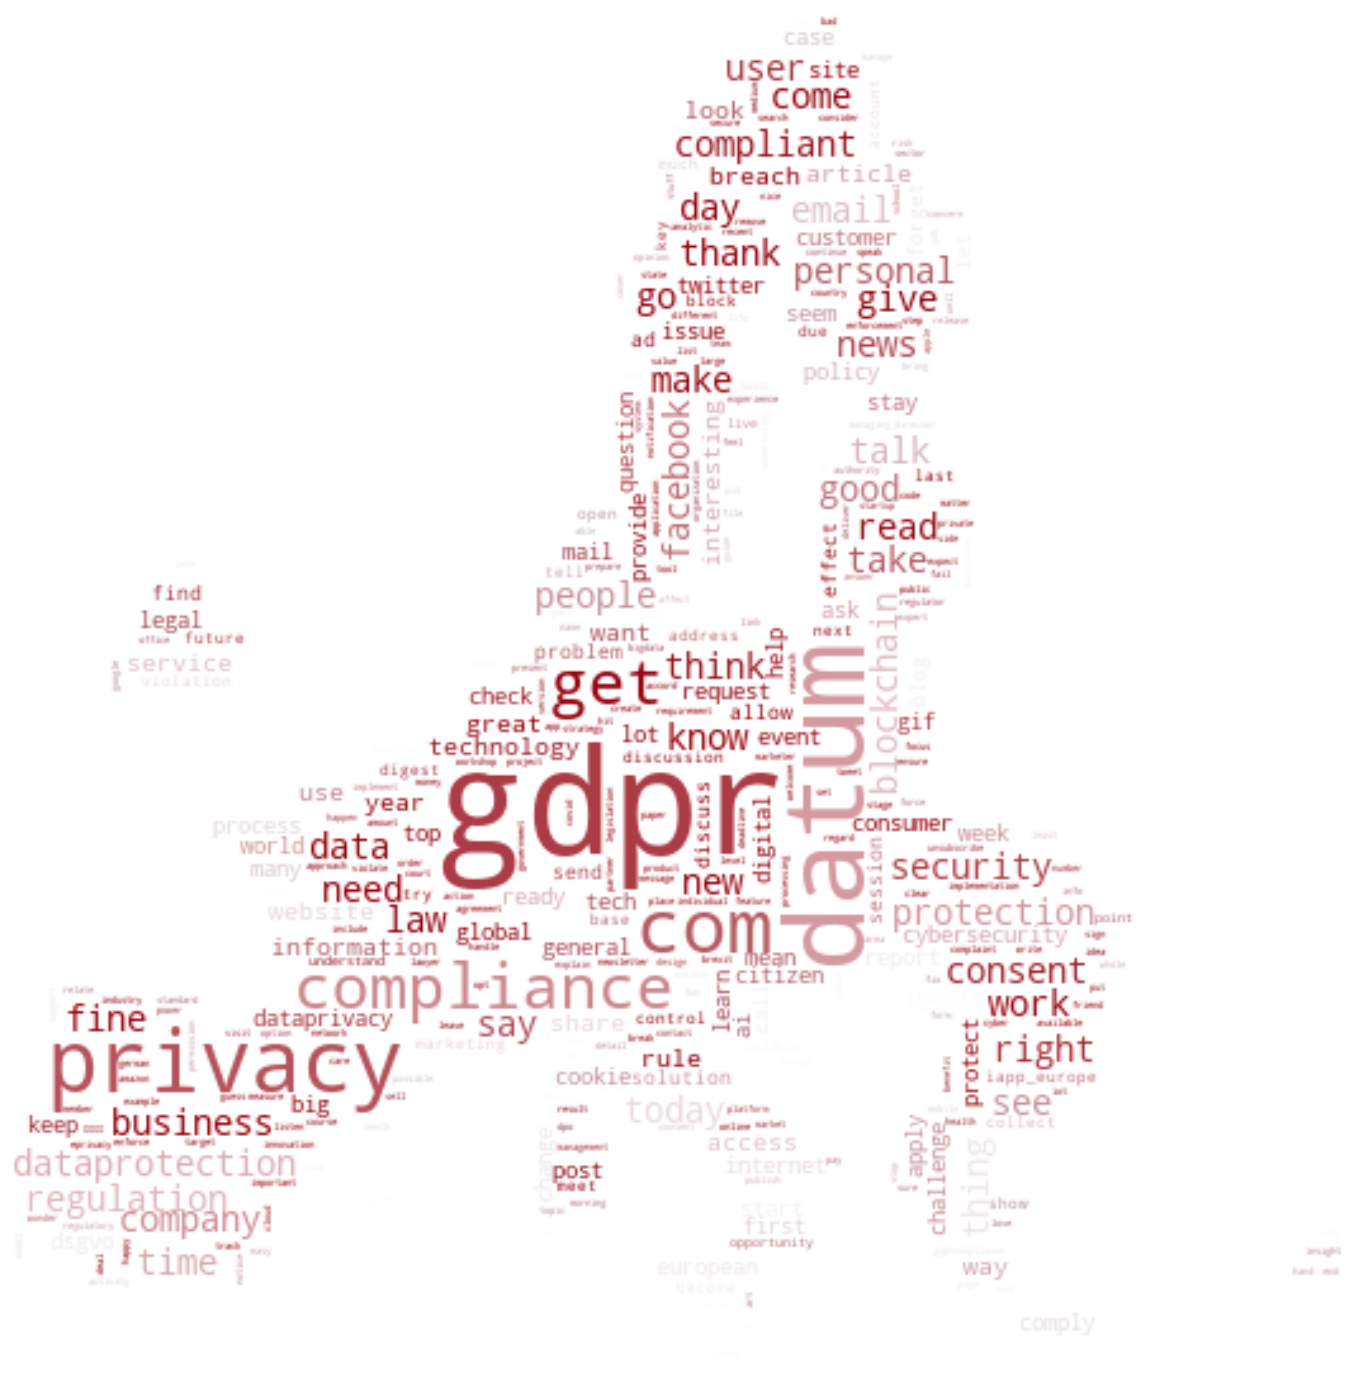

In [20]:
# Importing word cloud
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from PIL import Image

## Creating a masked wordcloud using TD-IDF
fig, ax = plt.subplots(figsize=(25,25))
custom_mask = np.array(Image.open("EU4.jpg"))
w = WordCloud(background_color = 'white',
              width=800,height=600,
              mask = custom_mask,
              mode='RGBA',
              max_words=2000).fit_words(topwords)
image_colors = ImageColorGenerator(custom_mask)
w.recolor(color_func = image_colors)
plt.imshow(w, interpolation="bilinear")
plt.axis("off")
plt.show()
fig.savefig('GDPR twitter_TFIDF_Wordcloud.png', dpi=800)

### LDA

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1)]]


In [22]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'mallet-2.0.8/bin/mallet'  # update this path
# mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
import os
os.environ.update({'MALLET_HOME':r'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/'})

mallet_path = 'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path


# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [23]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

[(0,
  [('datum', 0.20695178600032035),
   ('personal', 0.03700144161460836),
   ('information', 0.022425116130065672),
   ('share', 0.02162421912542047),
   ('company', 0.02082332212077527),
   ('request', 0.014095787281755567),
   ('provide', 0.013294890277110364),
   ('process', 0.012974531475252283),
   ('challenge', 0.01217363447060708),
   ('post', 0.012013455069678039)]),
 (1,
  [('protection', 0.04817541613316261),
   ('regulation', 0.04113316261203585),
   ('privacy', 0.028649167733674777),
   ('data', 0.028169014084507043),
   ('facebook', 0.026568501920614596),
   ('fine', 0.026248399487836107),
   ('dataprotection', 0.024807938540332905),
   ('company', 0.024007682458386685),
   ('security', 0.021286811779769526),
   ('cybersecurity', 0.02112676056338028)]),
 (2,
  [('gdpr', 0.07411050991965897),
   ('user', 0.03721921626496147),
   ('consent', 0.03180849319560584),
   ('work', 0.026725692736514182),
   ('read', 0.02426627315953435),
   ('article', 0.02279062141334645),
   

In [24]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=2)

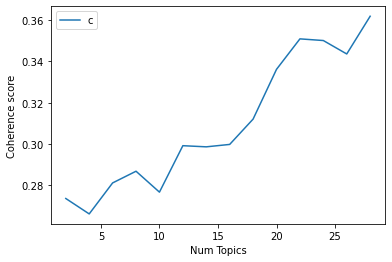

In [26]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [27]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
model_list

Num Topics = 2  has Coherence Value of 0.2737
Num Topics = 4  has Coherence Value of 0.2662
Num Topics = 6  has Coherence Value of 0.2812
Num Topics = 8  has Coherence Value of 0.2869
Num Topics = 10  has Coherence Value of 0.2767
Num Topics = 12  has Coherence Value of 0.2992
Num Topics = 14  has Coherence Value of 0.2987
Num Topics = 16  has Coherence Value of 0.2998
Num Topics = 18  has Coherence Value of 0.3121
Num Topics = 20  has Coherence Value of 0.3362
Num Topics = 22  has Coherence Value of 0.3509
Num Topics = 24  has Coherence Value of 0.3501
Num Topics = 26  has Coherence Value of 0.3436
Num Topics = 28  has Coherence Value of 0.3619


In [29]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.088*"gdpr" + 0.034*"compliant" + 0.022*"blockchain" + 0.021*"service" + '
  '0.020*"thing" + 0.015*"event" + 0.015*"internet" + 0.014*"week" + '
  '0.013*"blog" + 0.012*"solution" + 0.011*"dsgvo" + 0.010*"discussion" + '
  '0.010*"opportunity" + 0.009*"cloud" + 0.009*"industry" + 0.009*"future" + '
  '0.009*"german" + 0.009*"join" + 0.008*"meet" + 0.008*"store"'),
 (1,
  '0.129*"gdpr" + 0.050*"protection" + 0.043*"regulation" + 0.037*"law" + '
  '0.029*"data" + 0.017*"issue" + 0.015*"general" + 0.012*"global" + '
  '0.010*"citizen" + 0.009*"state" + 0.009*"include" + 0.008*"lead" + '
  '0.008*"month" + 0.008*"conference" + 0.008*"art" + 0.007*"legislation" + '
  '0.007*"implement" + 0.007*"high" + 0.007*"due" + 0.007*"enforcement"'),
 (2,
  '0.174*"gdpr" + 0.030*"business" + 0.029*"good" + 0.029*"time" + '
  '0.026*"email" + 0.017*"interesting" + 0.014*"ready" + 0.010*"marketing" + '
  '0.010*"show" + 0.009*"legal" + 0.009*"live" + 0.008*"approach" + '
  '0.008*"support" + 0.

In [30]:
ldadf = []
for i in range(len(optimal_model.print_topics(num_words= 20))):
    topic = optimal_model.print_topics(num_words= 20)[i]
    topic_num = 'topic' + ' ' + str(i+1)
    for j in range(len(topic[1].split(" + "))):
        term = topic[1].split(" + ")[j].split("*")[1][1:-1]
        ldanum = topic[1].split(" + ")[j].split("*")[0]
        ldadf.append({"topic": topic_num, 'term':term, 'lda_num':ldanum})
ldadf = pd.DataFrame(ldadf)
print(len(ldadf), ldadf.term.nunique())
ldadf

160 153


,topic,term,lda_num
0,topic 1,gdpr,0.088
1,topic 1,compliant,0.034
2,topic 1,blockchain,0.022
3,topic 1,service,0.021
4,topic 1,thing,0.020
...,...,...,...
155,topic 8,part,0.008
156,topic 8,content,0.007
157,topic 8,small,0.007
158,topic 8,private,0.007


In [26]:
# Visualize the topics
# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

AttributeError: 'LdaMallet' object has no attribute 'inference'

In [31]:
ldadf.to_excel("GDPR twitter LDAdf_final2_0329.xlsx", index=False)

In [32]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.2198,"gdpr, business, good, time, email, interesting...",This is the kind of behavior that the EU GDPR ...
1,1,6.0,0.1714,"datum, personal, consent, company, people, inf...",님과 님에게 보내는 답글 And in Europe it is going to be...
2,2,1.0,0.1455,"gdpr, protection, regulation, law, data, issue...",A Publisher’s Guide To GDPR: AdExchanger | Wit...
3,3,2.0,0.1706,"gdpr, business, good, time, email, interesting...","님, 다른 사람 6명에게 보내는 답글 As Benjamin mentioned, t..."
4,4,0.0,0.1440,"gdpr, compliant, blockchain, service, thing, e...","2018PSD2, GDPR, MiFID2... excited to see how t..."
5,5,1.0,0.1597,"gdpr, protection, regulation, law, data, issue...",Proud owner of my #GDPR DPO Data Protection Of...
6,6,3.0,0.1515,"gdpr, day, great, policy, protect, update, sta...",Nice GDPR overview. 1 1
7,7,6.0,0.2397,"datum, personal, consent, company, people, inf...","First recruiter to call after 25th of may. ""Wh..."
8,8,5.0,0.1473,"compliance, gdpr, make, fine, read, article, r...",님에게 보내는 답글 EU GDPR rules to be launched later...
9,9,4.0,0.1473,"privacy, dataprotection, today, news, security...",님과 님에게 보내는 답글 Are you sure you don’t mix it u...


In [33]:
df_dominant_topic.to_excel("GDPR twitter_토픽별docu.xlsx",index=False)

### NER

In [34]:
import spacy
from spacy import displacy
import en_core_web_sm

nlp = en_core_web_sm.load()
def NER(lst):
    doc = nlp(lst)
    NERlst = []
    for X in doc.ents:
    #     NERlst.append((X.text, X.label_))
        if X.label_ == 'ORG':
            NERlst.append(X.text)

    return NERlst
qq =  df

qq['content'] = data_words_nostops
nlpdf = qq[['content']]
de_doc = []
for i in range(len(data_words_nostops)):
    t = ' '.join(data_words_nostops[i])
    de_doc.append(t)
qq['content'] = de_doc
nlpdf = qq[['content']]    
nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))
nlpdf

,content,NER result
0,gdpr affect dlvr qrp qg,[]
1,hours starting see mark say data privacy gdpr ...,[]
2,airlines etc beware gdpr kicking may ready new...,[]
3,looking guidance gdpr article contract standar...,[]
4,marketers dont race bottom better top gdpr rgp...,[]
...,...,...
3493,님에게 보내는 답글 unfortunately data protection laws ...,[]
3494,gdpr services market size analysis forecast ke...,[]
3495,님에게 보내는 답글 read article area live protects pri...,[eu enforces general data protection]
3496,eu gdpr action,[eu gdpr action]


In [35]:
from nltk.probability import FreqDist
NERll = nlpdf['NER result'].sum()
fdist = FreqDist(NERll)
top_20 = fdist.most_common(20)
top_20

[('ec', 18),
 ('조회수', 17),
 ('eu data protection', 13),
 ('european union', 11),
 ('pdf', 10),
 ('ibm', 9),
 ('eu enforces general data protection', 9),
 ('nl', 8),
 ('microsoft', 8),
 ('apple', 8),
 ('eu doceo', 7),
 ('general data protection', 6),
 ('eu general data protection', 6),
 ('infosec', 6),
 ('android', 6),
 ('eu press release cdp gdpr crm data', 6),
 ('un', 5),
 ('max', 5),
 ('bbc news', 5),
 ('european commission', 5)]